In [9]:
import sys
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

from Src import \
        SignLanguageModel, \
        PreprocessingPipeline, \
        Visualizer, \
        DatasetSplitter

from config import \
        CLASSES_LIST, \
        MODEL_PATH, \
        INPUT_SHAPE, \
        IMAGE_SIZE, \
        MODEL_PATH, \
        BATCH_SIZE, \
        TRAIN_PROPORTION, \
        OPTIMIZER, \
        LOSS, \
        METRICS

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [10]:
prep_pipeline_func = PreprocessingPipeline(target_size=IMAGE_SIZE, is_gray=False)
visualizer_tf_data = Visualizer(figsize_per_image=(2,2))
splitter = DatasetSplitter(batch_size=BATCH_SIZE, train_split=TRAIN_PROPORTION)

In [11]:
sibi_train_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_train_dataset.tfrecord", compression="GZIP")
sibi_test_dataset_loaded = tf.data.Dataset.load("../Assets/datasets/SIBI_test_dataset.tfrecord", compression="GZIP")

In [12]:
print(f'info train data: {sibi_train_dataset_loaded}')
print(f'number of train data: {len(sibi_train_dataset_loaded)}')
print()
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
number of train data: 5200

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [13]:
sibi_train_dataset_augmented = sibi_train_dataset_loaded.map(prep_pipeline_func.augment_image)
sibi_train_dataset_cached = sibi_train_dataset_augmented.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 1)
    dtype-image: <dtype: 'float32'>
    max-intensity: 0.90172278881073
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
    original-label: Q
    label-shape: (26,)
    image-type: <dtype: 'float32'>


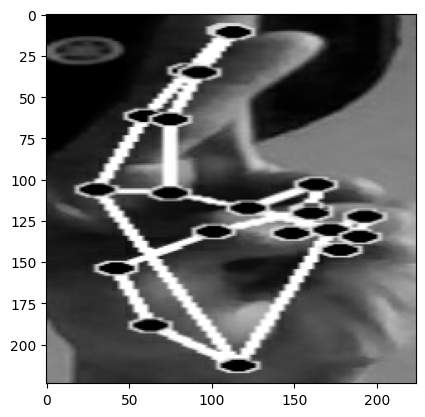

In [14]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_cached.shuffle(buffer_size=sibi_train_dataset_cached.cardinality().numpy()).take(1):
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

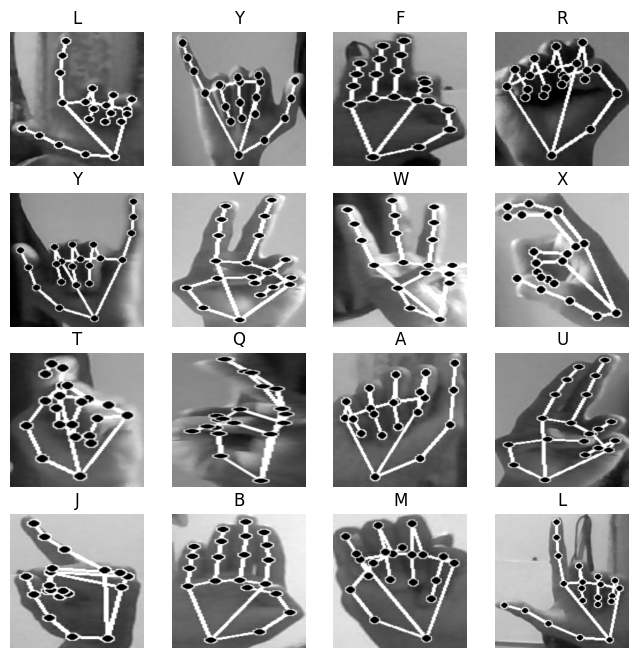

In [15]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_train_dataset_cached, num_images=16, classes_list=CLASSES_LIST)

In [16]:
train_dataset_batched, valid_dataset_batched = splitter.split_and_prepare(sibi_train_dataset_cached)

=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Training Split: 0.9
Number of data: 4680
AFTER BATCH: 32
Number of data: 147
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(26,), dtype=tf.float32, name=None))>
Validation Split: 0.1
Number of data: 520
AFTER BATCH: 32
Number of data: 17


In [17]:
sibi_train_dataset_3_channels = train_dataset_batched.map(prep_pipeline_func.processing_data_train_to_VGG_input)
sibi_valid_dataset_3_channels = valid_dataset_batched.map(prep_pipeline_func.processing_data_train_to_VGG_input)

sibi_train_dataset_3_channels_cached = sibi_train_dataset_3_channels.cache()
sibi_valid_dataset_3_channels_cached = sibi_valid_dataset_3_channels.cache()

=======================Check Train Data======================
    shape-image: (224, 224, 3)
    dtype-image: <dtype: 'float32'>
    max-intensity: 1.0
    min-intensity: 0.0

    one-hot-label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0.]
    original-label: Y
    label-shape: (26,)
    image-type: <dtype: 'float32'>


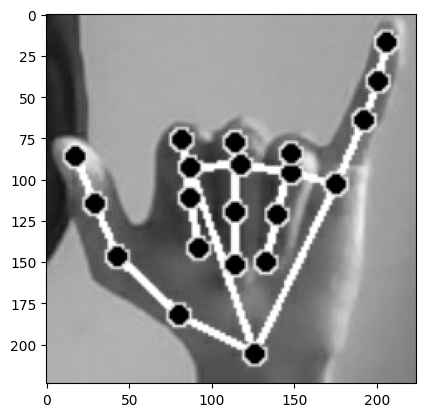

In [18]:
# Menampilkan contoh data yang telah diubah
for image, label in sibi_train_dataset_3_channels_cached.shuffle(buffer_size=sibi_train_dataset_3_channels_cached.cardinality().numpy()).take(1):
    image, label = image[0], label[0]
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {tf.reduce_max(image)}
    min-intensity: {tf.reduce_min(image)}

    one-hot-label: {label.numpy()}
    original-label: {CLASSES_LIST[tf.argmax(label).numpy()]}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
    )

    plt.imshow(image, cmap='gray')
plt.show()

In [19]:
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

In [20]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
my_model=SignLanguageModel(
    input_shape=INPUT_SHAPE, 
    num_classes=len(CLASSES_LIST), 
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
)
my_model.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,046,362 (57.40 MB)

 Trainable params: 331,674 (1.27 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,  # Path untuk menyimpan model
    monitor='val_loss',  # Metrik yang dipantau
    save_best_only=True,  # Hanya menyimpan model terbaik
    save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
    mode='min',  # Mode untuk memantau metrik (min untuk loss)
    verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=25,
  restore_best_weights=True,
  verbose=1
)

history = my_model.train(
    sibi_train_dataset_3_channels_cached,
    validation_data=sibi_valid_dataset_3_channels_cached,
    epochs=300,
    callbacks=[
    plateau_callback,
    early_stopping,
    checkpoint_callback
  ]
)

In [64]:
load_model=SignLanguageModel(model_path=MODEL_PATH)

In [30]:
# Evaluasi model yang dimuat
loaded_evaluation = load_model.model.evaluate(sibi_valid_dataset_3_channels_cached)
print(f'Evaluation on validation data (loaded model): {loaded_evaluation}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step - accuracy: 0.9957 - loss: 0.0270
Evaluation on validation data (loaded model): [0.014527291059494019, 0.9980769157409668]


In [70]:
def evaluate_model(model, test_dataset, class_names):
  """
  Evaluate the model using confusion matrix, classification report, and other metrics.
  
  Args:
  - model: Trained Keras model.
  - test_dataset: tf.data.Dataset for evaluation.
  - class_names: List of class names corresponding to the labels.
  """
  # Extract the true labels and predicted labels
  y_true = []
  y_pred = []

  for images, labels in test_dataset:
      predictions = model.predict(images, verbose=0)
      y_true.extend(tf.argmax(labels, axis=1).numpy())
      y_pred.extend(tf.argmax(predictions, axis=1).numpy())

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Display confusion matrix with class names
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # Print classification report with class names
  print("Classification Report:")
  print(classification_report(y_true, y_pred))

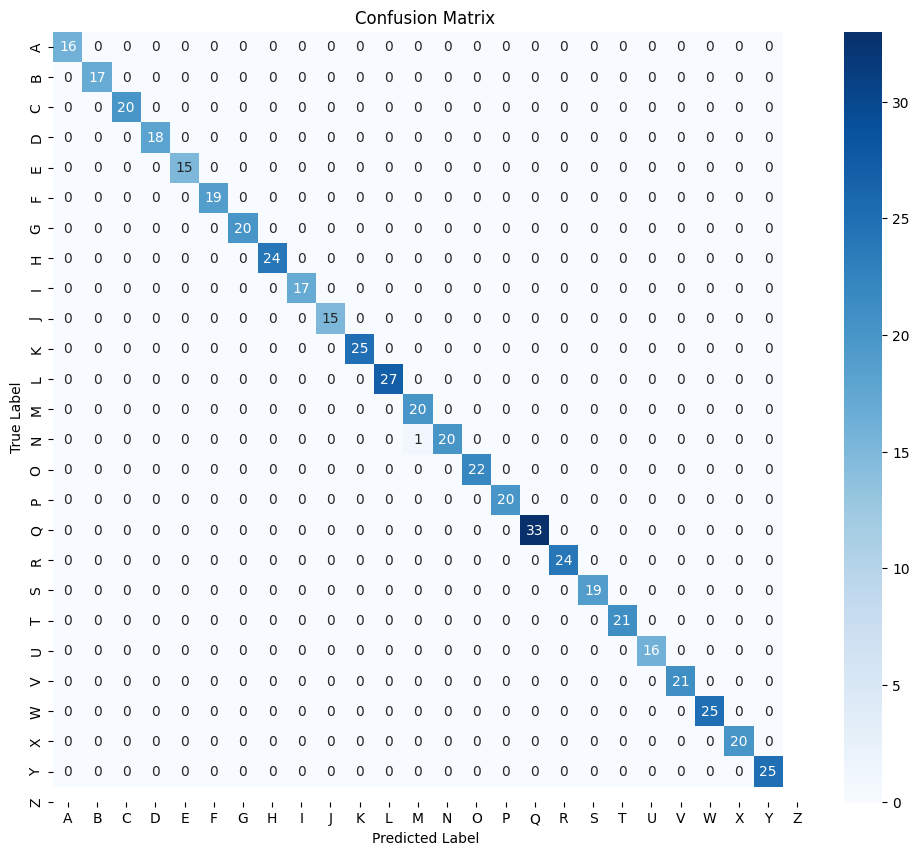

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        19
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        27
          12       0.95      1.00      0.98        20
          13       1.00      0.95      0.98        21
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        20
          16       1.00      1.00      1.00        33
    

In [71]:
evaluate_model(load_model.model, sibi_valid_dataset_3_channels_cached, CLASSES_LIST)

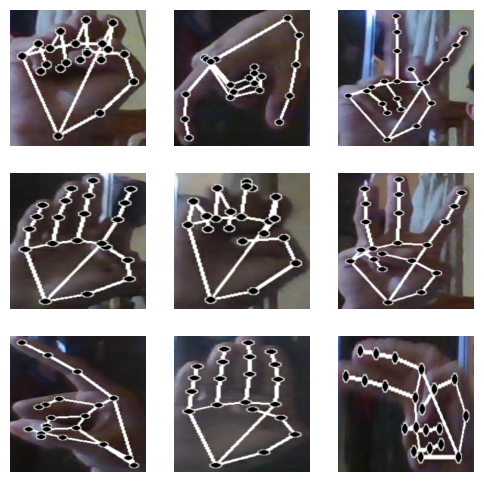

In [19]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_test_dataset_loaded, num_images=9)

In [21]:
print(f'info test data: {sibi_test_dataset_loaded}')
print(f'number of test data: {len(sibi_test_dataset_loaded)}')

info test data: <_LoadDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


In [22]:
sibi_test_dataset_loaded_rgb = sibi_test_dataset_loaded.map(prep_pipeline_func.processing_data_test_to_VGG_input)
sibi_test_dataset_loaded_rgb_cached = sibi_test_dataset_loaded_rgb.cache()

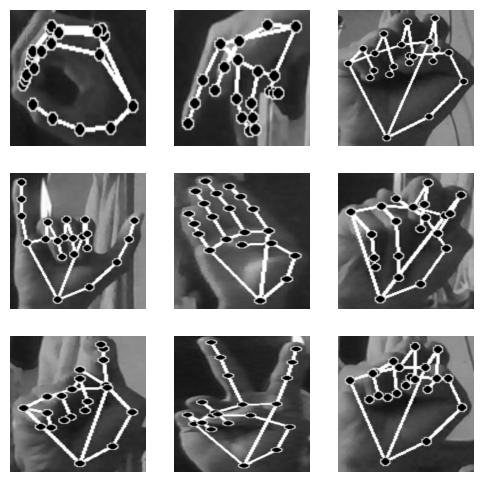

In [23]:
visualizer_tf_data.show_multiple_images_in_tf_data(sibi_test_dataset_loaded_rgb_cached, num_images=9)

In [9]:
print(f'info test data: {sibi_test_dataset_loaded_rgb_cached}')
print(f'number of test data: {len(sibi_test_dataset_loaded_rgb_cached)}')

info test data: <CacheDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>
number of test data: 390


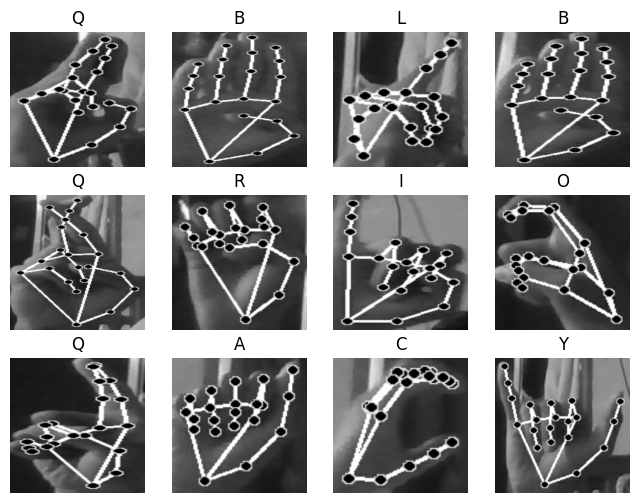

In [27]:
visualizer_tf_data.show_multiple_images_with_label_pred_tf_data(model=load_model.model, dataset=sibi_test_dataset_loaded_rgb_cached, num_images=12, classes_list=CLASSES_LIST)